In [19]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sb
sb.set()
h = 0.02  # step size in the mesh

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


In [ ]:
seed = 1337
layer = "all"
np.random.seed(seed)
n_hl = 12
hidden_dim = 768

In [ ]:
def get_inputs(filename, layer):
    """Read data from pkl file and prepare for training."""
    file = open(filename + ".pkl", "rb")
    data = pickle.load(file)
    author_ids, data_x, data_y = list(zip(*data))
    file.close()

    # alphaW is responsible for which BERT layer embedding we will be using
    if layer == "all":
        alphaW = np.full([n_hl], 1 / n_hl)

    else:
        alphaW = np.zeros([n_hl])
        alphaW[int(layer) - 1] = 1

    # just changing the way data is stored (tuples of minibatches) and
    # getting the output for the required layer of BERT using alphaW
    inputs = []
    targets = []
    n_batches = len(data_y)
    print("n_batches:", n_batches)
    for ii in range(n_batches):
        extra_inputs = np.einsum("k,kij->ij", alphaW, data_x[ii])
        extra_targets = data_y[ii]
        if len(extra_inputs) == len(extra_targets):
            inputs.extend(extra_inputs)
            targets.extend(data_y[ii])
        else:
            print("skipped a batch")
        
    inputs = np.array(inputs)
    full_targets = np.array(targets)

    return inputs, full_targets

In [32]:
filename = "embeddings/reddit-albert-base-mean-130k_cleaned"
# filename = "embeddings/reddit-albert-base-mean-12k_cleaned"
# filename = "embeddings/reddit-albert-base-mean-5k_cleaned"
data_x, data_y = get_inputs(filename, layer)

#maybe do this
data_x = StandardScaler().fit_transform(data_x)
x_train, x_test, real_y_train, real_y_test = train_test_split(data_x, data_y, test_size = 0.2)

n_batches: 4105


In [33]:
labels = ["Extraversion (E) vs Introversion (I)", "Intuition (N) vs Sensing (S)", "Feeling (F) vs Thinking (T)", "Judging (J) vs Perceiving (P)" ]
#iterate through indexes from 0 to 4
idx = 0
y_train = real_y_train[:, idx]
y_test = real_y_test[:, idx]

In [34]:
x_min, x_max = np.min(data_x) - 0.5, np.max(data_x) + 0.5
y_min, y_max = np.min(data_y) - 0.5, np.max(data_y) + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Trying out: Nearest Neighbors
Labelling: Extraversion (E) vs Introversion (I)

Classification Accuracy:	 0.5169902912621359
F1 score: 0.4844559585492228
Precision: 0.4815450643776824
Recall: 0.48740225890529976
Accuracy: 0.5169902912621359
Took 89 seconds




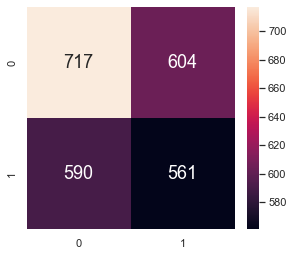

In [24]:
figure = plt.figure(figsize=(27, 9))
i = 1

# iterate over classifiers
name = names[i-1]
clf = classifiers[i-1]
print(f"Trying out: {name}")
print(f"Labelling: {labels[idx]}\n")
ax = plt.subplot(2, 5, 1)
start = time()

clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
y_pred = clf.predict(x_test)

# Check the Goodness of Fit (on Test Data)
print("Classification Accuracy:\t", clf.score(x_test, y_test))


conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

#Precision = TruePositives / (TruePositives + FalsePositives)
precision = tp / (tp + fp)
recall = tp / (tp+fn)
accuracy = (tp + tn) / (tp+tn+fp+fn)
f1 = (2 * (precision * recall)) / (precision + recall)
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Took {int(time() - start)} seconds\n")
print()
hm = sb.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})

Trying out: Linear SVM
Labelling: Extraversion (E) vs Introversion (I)

Classification Accuracy:	 0.5372168284789643
F1 score: 0.4674115456238361
Precision: 0.5035105315947843
Recall: 0.43614248479582973
Accuracy: 0.5372168284789643
Took 254 seconds




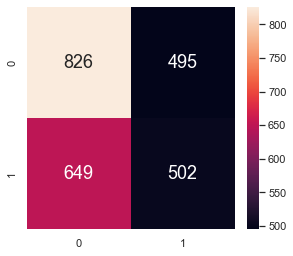

In [25]:
figure = plt.figure(figsize=(27, 9))
i = 2

# iterate over classifiers
name = names[i-1]
clf = classifiers[i-1]
print(f"Trying out: {name}")
print(f"Labelling: {labels[idx]}\n")
ax = plt.subplot(2, 5, 1)
start = time()

clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
y_pred = clf.predict(x_test)

# Check the Goodness of Fit (on Test Data)
print("Classification Accuracy:\t", clf.score(x_test, y_test))


conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

#Precision = TruePositives / (TruePositives + FalsePositives)
precision = tp / (tp + fp)
recall = tp / (tp+fn)
accuracy = (tp + tn) / (tp+tn+fp+fn)
f1 = (2 * (precision * recall)) / (precision + recall)
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Took {int(time() - start)} seconds\n")
print()
hm = sb.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})

Trying out: RBF SVM
Labelling: Extraversion (E) vs Introversion (I)

Classification Accuracy:	 0.558252427184466
F1 score: 0.10049423393739704
Precision: 0.9682539682539683
Recall: 0.052997393570807995
Accuracy: 0.558252427184466
Took 272 seconds




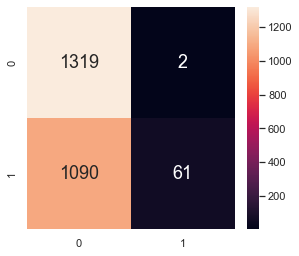

In [26]:
figure = plt.figure(figsize=(27, 9))
i = 3

# iterate over classifiers
name = names[i-1]
clf = classifiers[i-1]
print(f"Trying out: {name}")
print(f"Labelling: {labels[idx]}\n")
ax = plt.subplot(2, 5, 1)
start = time()

clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
y_pred = clf.predict(x_test)

# Check the Goodness of Fit (on Test Data)
print("Classification Accuracy:\t", clf.score(x_test, y_test))


conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

#Precision = TruePositives / (TruePositives + FalsePositives)
precision = tp / (tp + fp)
recall = tp / (tp+fn)
accuracy = (tp + tn) / (tp+tn+fp+fn)
f1 = (2 * (precision * recall)) / (precision + recall)
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Took {int(time() - start)} seconds\n")
print()
hm = sb.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})

In [ ]:
figure = plt.figure(figsize=(27, 9))
i = 4

# iterate over classifiers
name = names[i-1]
clf = classifiers[i-1]
print(f"Trying out: {name}")
print(f"Labelling: {labels[idx]}\n")
ax = plt.subplot(2, 5, 1)
start = time()

clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
y_pred = clf.predict(x_test)

# Check the Goodness of Fit (on Test Data)
print("Classification Accuracy:\t", clf.score(x_test, y_test))


conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

#Precision = TruePositives / (TruePositives + FalsePositives)
precision = tp / (tp + fp)
recall = tp / (tp+fn)
accuracy = (tp + tn) / (tp+tn+fp+fn)
f1 = (2 * (precision * recall)) / (precision + recall)
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Took {int(time() - start)} seconds\n")
print()
hm = sb.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})

Trying out: Gaussian Process
Labelling: Judging (J) vs Perceiving (P)



Trying out: Decision Tree
Labelling: Extraversion (E) vs Introversion (I)

Classification Accuracy:	 0.5153721682847896
F1 score: 0.44330855018587356
Precision: 0.47652347652347654
Recall: 0.4144222415291051
Accuracy: 0.5153721682847896
Took 9 seconds




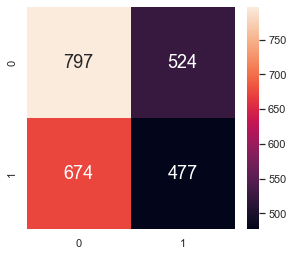

In [27]:
figure = plt.figure(figsize=(27, 9))
i = 5

# iterate over classifiers
name = names[i-1]
clf = classifiers[i-1]
print(f"Trying out: {name}")
print(f"Labelling: {labels[idx]}\n")
ax = plt.subplot(2, 5, 1)
start = time()

clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
y_pred = clf.predict(x_test)

# Check the Goodness of Fit (on Test Data)
print("Classification Accuracy:\t", clf.score(x_test, y_test))


conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

#Precision = TruePositives / (TruePositives + FalsePositives)
precision = tp / (tp + fp)
recall = tp / (tp+fn)
accuracy = (tp + tn) / (tp+tn+fp+fn)
f1 = (2 * (precision * recall)) / (precision + recall)
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Took {int(time() - start)} seconds\n")
print()
hm = sb.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})

Trying out: Random Forest
Labelling: Extraversion (E) vs Introversion (I)

Classification Accuracy:	 0.5420711974110033
F1 score: 0.4831050228310502
Precision: 0.5091434071222329
Recall: 0.4596003475238923
Accuracy: 0.5420711974110033
Took 0 seconds




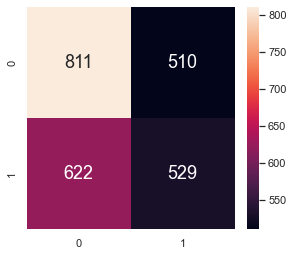

In [28]:
figure = plt.figure(figsize=(27, 9))
i = 6

# iterate over classifiers
name = names[i-1]
clf = classifiers[i-1]
print(f"Trying out: {name}")
print(f"Labelling: {labels[idx]}\n")
ax = plt.subplot(2, 5, 1)
start = time()

clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
y_pred = clf.predict(x_test)

# Check the Goodness of Fit (on Test Data)
print("Classification Accuracy:\t", clf.score(x_test, y_test))


conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

#Precision = TruePositives / (TruePositives + FalsePositives)
try:
    precision = tp / (tp + fp)
except:
    precision = 0
try:
    
    recall = tp / (tp+fn)
except:
    recall = 0
accuracy = (tp + tn) / (tp+tn+fp+fn)
try:
    f1 = (2 * (precision * recall)) / (precision + recall)
    print(f"F1 score: {f1}")
except:
    print(f"F1 score: not applicable")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Took {int(time() - start)} seconds\n")
print()
hm = sb.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})

Trying out: Neural Net
Labelling: Extraversion (E) vs Introversion (I)

Classification Accuracy:	 0.5303398058252428
F1 score: 0.4997845756139595
Precision: 0.49572649572649574
Recall: 0.5039096437880104
Accuracy: 0.5303398058252428
Took 10 seconds




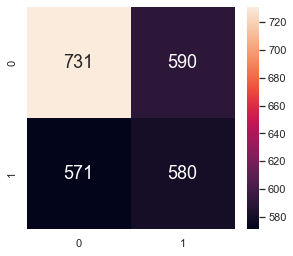

In [29]:
figure = plt.figure(figsize=(27, 9))
i = 7

# iterate over classifiers
name = names[i-1]
clf = classifiers[i-1]
print(f"Trying out: {name}")
print(f"Labelling: {labels[idx]}\n")
ax = plt.subplot(2, 5, 1)
start = time()

clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
y_pred = clf.predict(x_test)

# Check the Goodness of Fit (on Test Data)
print("Classification Accuracy:\t", clf.score(x_test, y_test))


conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

#Precision = TruePositives / (TruePositives + FalsePositives)
precision = tp / (tp + fp)
recall = tp / (tp+fn)
accuracy = (tp + tn) / (tp+tn+fp+fn)
f1 = (2 * (precision * recall)) / (precision + recall)
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Took {int(time() - start)} seconds\n")
print()
hm = sb.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})

Trying out: AdaBoost
Labelling: Extraversion (E) vs Introversion (I)

Classification Accuracy:	 0.529126213592233
F1 score: 0.4530075187969924
Precision: 0.49334698055271237
Recall: 0.41876629018245004
Accuracy: 0.529126213592233
Took 41 seconds




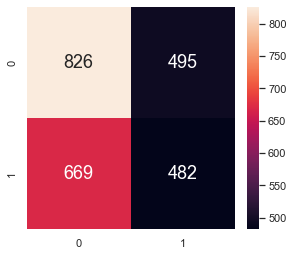

In [30]:
figure = plt.figure(figsize=(27, 9))
i = 8

# iterate over classifiers
name = names[i-1]
clf = classifiers[i-1]
print(f"Trying out: {name}")
print(f"Labelling: {labels[idx]}\n")
ax = plt.subplot(2, 5, 1)
start = time()

clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
y_pred = clf.predict(x_test)

# Check the Goodness of Fit (on Test Data)
print("Classification Accuracy:\t", clf.score(x_test, y_test))


conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

#Precision = TruePositives / (TruePositives + FalsePositives)
precision = tp / (tp + fp)
recall = tp / (tp+fn)
accuracy = (tp + tn) / (tp+tn+fp+fn)
f1 = (2 * (precision * recall)) / (precision + recall)
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Took {int(time() - start)} seconds\n")
print()
hm = sb.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})

Trying out: Naive Bayes
Labelling: Extraversion (E) vs Introversion (I)

Classification Accuracy:	 0.5384304207119741
F1 score: 0.49535603715170284
Precision: 0.5045045045045045
Recall: 0.48653344917463076
Accuracy: 0.5384304207119741
Took 0 seconds




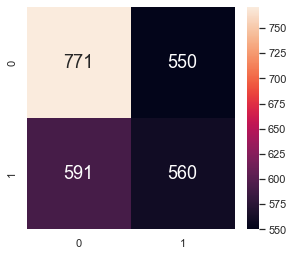

In [31]:
figure = plt.figure(figsize=(27, 9))
i = 9

# iterate over classifiers
name = names[i-1]
clf = classifiers[i-1]
print(f"Trying out: {name}")
print(f"Labelling: {labels[idx]}\n")
ax = plt.subplot(2, 5, 1)
start = time()

clf.fit(x_train, y_train)
score = clf.score(x_test, y_test)
y_pred = clf.predict(x_test)

# Check the Goodness of Fit (on Test Data)
print("Classification Accuracy:\t", clf.score(x_test, y_test))


conf_matrix = confusion_matrix(y_test, y_pred)

tn, fp = conf_matrix[0]
fn, tp = conf_matrix[1]

#Precision = TruePositives / (TruePositives + FalsePositives)
precision = tp / (tp + fp)
recall = tp / (tp+fn)
accuracy = (tp + tn) / (tp+tn+fp+fn)
f1 = (2 * (precision * recall)) / (precision + recall)
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"Took {int(time() - start)} seconds\n")
print()
hm = sb.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt=".0f", annot_kws={"size": 18})